### Pregunta 1 - Ítem 2

100%|██████████| 100000/100000 [00:01<00:00, 98092.66it/s]


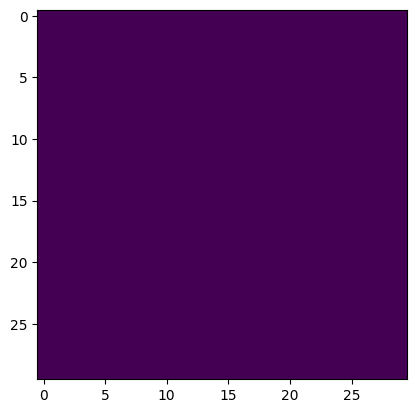

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def prob_flip(Estado, i, j, beta):
    assert (i != len(Estado[0, :]) - 1) and (j != len(Estado[0, :]) - 1) and (i*j != 0), "No se puede cambiar un borde."
    valor = Estado[i, j]
    vecinos = Estado[[i-1, i, i, i+1], [j, j-1, j+1, j]]
    prob = np.exp(-2*beta*np.sum(valor*vecinos))
    return prob

def isingMH(N, beta, nf, x0):
    assert np.any(x0[0, :]) and np.any(x0[-1, :]) and np.any(x0[:, 0]) and np.any(x0[:, -1]), "La condición inicial debe tener borde 1."
    state = x0
    for _ in trange(nf):
        i, j = np.random.randint(1, N-1, 2)
        prob = prob_flip(state, i, j, beta)
        if np.random.rand() <= prob:
            state[i, j] = -state[i, j]
    return state

if __name__ == "__main__":
    N = 30
    beta = 1.0
    nf = 100_000
    x0 = np.ones((N, N))
    state = isingMH(N, beta, nf, x0)
    plt.imshow(state)
    plt.show()

#### Verifiquemos que vemos la transición de fase que deberíamos

In [66]:
def magnetización(estados):
    return np.mean(estados[1:(N-1), 1:(N-1)])

beta_sweep = np.linspace(0.1, 1, 30)
magnetizaciones = []

for beta in beta_sweep:
    state = isingMH(N, beta, nf, x0)
    magnetizaciones.append(magnetización(state))

100%|██████████| 100000/100000 [00:01<00:00, 87430.40it/s]


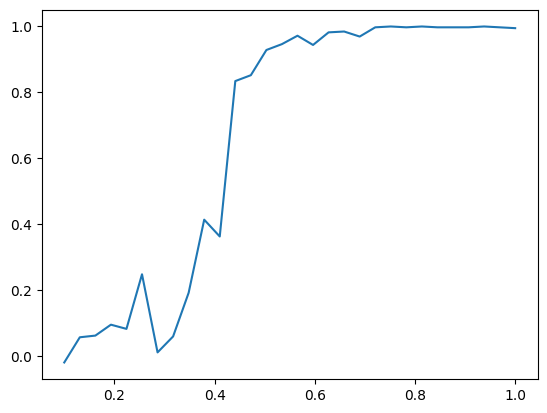

In [67]:
plt.clf()
plt.plot(beta_sweep, magnetizaciones)
plt.show()

Si se ve! Deberíamos sacar más estadística para asegurarse pero tiene buena pinta.

### Pregunta 2 - Ítem 3

100%|██████████| 999999/999999 [00:30<00:00, 32271.25it/s]
/var/folders/vl/sstvv2kj5ydgfftm30fx_db00000gn/T/ipykernel_51206/35793774.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


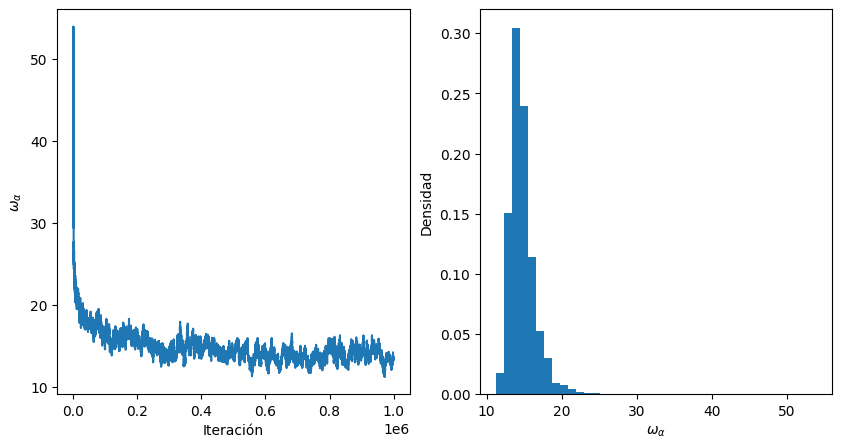

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def integral_de_camino(camino, posiciones, alpha):
    posiciones_ordenadas = posiciones[camino]
    return np.sum(np.linalg.norm(posiciones_ordenadas - np.roll(posiciones_ordenadas, -1, axis=0), axis=1)**alpha)

def prob_permutar(camino, i, j, posiciones, beta, alpha):
    assert (i*j != 0), "No se puede cambiar el punto de partida/llegada."
    camino_permutado = camino.copy()
    camino_permutado[[i, j]] = camino_permutado[[j, i]]
    prob_permutar = np.exp(-beta*(integral_de_camino(camino_permutado, posiciones, alpha) - integral_de_camino(camino, posiciones, alpha)))
    return prob_permutar

def vendedorViajeroSA(constante, posiciones, alpha, nf):
    N = len(posiciones[:, 0])
    array_caminos = np.zeros((nf, N), dtype=int)
    array_caminos[0, :] = np.arange(N) # sería nuestro sigma. Inicializamos con la identidad. No cambiamos ni la primera ni la última ciudad.
    beta_sucesión = np.log(np.arange(1, nf) + np.exp(1))/constante
    for i in trange(nf -1):
        beta = beta_sucesión[i]
        camino = array_caminos[i, :]
        ciudad_i, ciudad_j = np.random.randint(1, N, 2)
        prob = prob_permutar(camino, ciudad_i, ciudad_j, posiciones, beta, alpha)
        if np.random.rand() <= prob:
            camino[[ciudad_i, ciudad_j]] = camino[[ciudad_j, ciudad_i]]
        array_caminos[i+1, :] = camino
    return array_caminos, [integral_de_camino(camino, posiciones, alpha) for camino in array_caminos]

if __name__ == "__main__":
    N = 100
    alpha = 1.0
    nf = 1_000_000
    constante = 1.0
    posiciones = np.random.rand(N, 2)
    caminos, integrales = vendedorViajeroSA(constante, posiciones, alpha, nf)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(integrales)
    axes[0].set_xlabel("Iteración")
    axes[0].set_ylabel(r"$\omega_\alpha$")
    axes[1].hist(integrales, bins=40, density=True)
    axes[1].set_xlabel(r"$\omega_\alpha$")
    axes[1].set_ylabel("Densidad")
    fig.show()